# Recurrent Neural Network
Table of contents:
- [Overview](#overview)
- [Language Model](#language)
- [Gradient Flow](#gradient)
- [Long Short Term Memory(LSTM)](#LSTM)
- [Variants on LSTM](#variants)
- [Reference](#reference)

<a name='overview'></a>
## Overview
**Recurrent neural networks** are networks with loops in them, allowing information to persist.
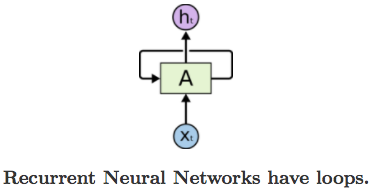
The hidden layer is defined recursively.
$$
h_t = f_W(h_{t-1},x_t)
$$
Note that the same function and the same set of parameters are used at every time step.
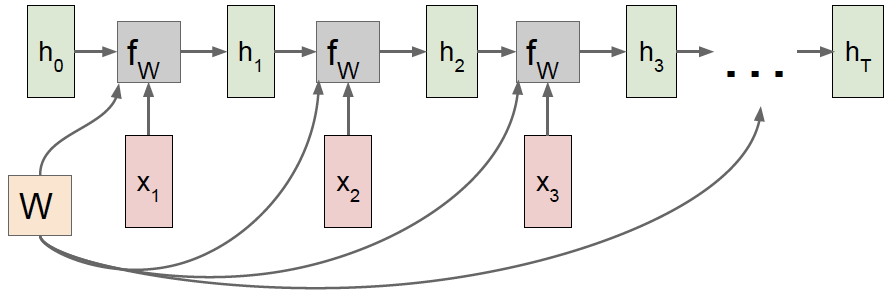
A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor.
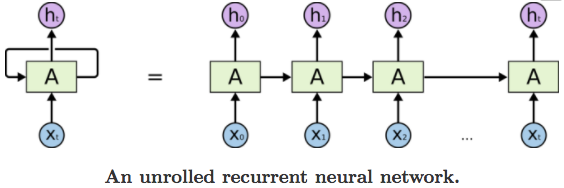
Below shows various RNN applications.
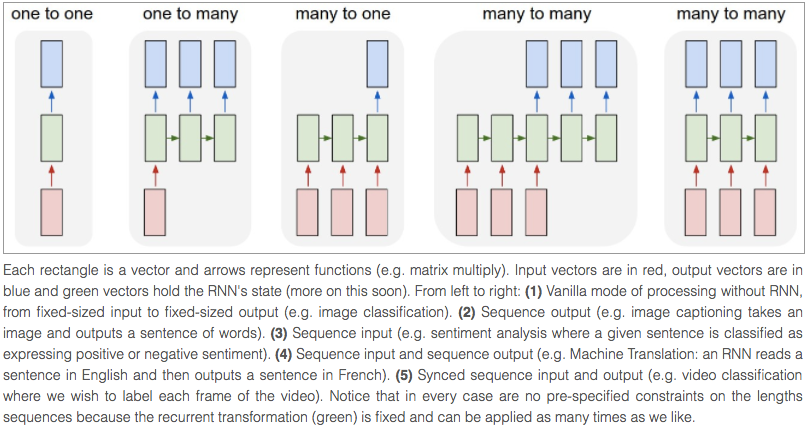

<a name='language'></a>
## Character-Level Language Models
Given the RNN a huge chunk of text, we want it to model the probability distribution of the next character in the sequence given a sequence of previous characters. It then generates new text one character at a time.

As a working example, suppose we only had a vocabulary of four possible letters “helo”, and wanted to train an RNN on the training sequence “hello”.
![working-example-train](./figures/rnn/working-example-train.png)

Notice that the first time the character “l” is input, the target is “l”, but the second time the target is “o”. The RNN therefore cannot rely on the input alone and must use its recurrent connection to keep track of the context to achieve this task.

At test time, we feed a character into the RNN and get a distribution over what characters are likely to come next. We sample from this distribution, and feed it right back in to get the next letter. Repeat this process and you’re sampling text! Lets now train an RNN on different datasets and see what happens.
![working-example-test](./figures/rnn/working-example-test.png)

<a name='gradient'></a>
## Gradient Flow
Suppose
$$
h_t = tanh(W_{hh}h_{t-1}+W_{xh}x_t) = 
tanh\left(W\begin{bmatrix} h_{t-1} \\ x_t \end{bmatrix}\right)
$$
![gradient-flow](./figures/rnn/gradient-flow.png)
Computing gradient of $h_1$ involves many factors of $W$ (and repeated tahn).
Let $E_t$ be the loss and $y_t$ be the output at time $t$.
By the chain rule for RNN,
$$
\frac{\partial E_t}{\partial W} = \sum_{k=1}^t\frac{\partial E_t}{\partial y_t}
\frac{\partial y_t}{\partial h_t}\frac{\partial h_t}{\partial h_k}
\frac{\partial h_k}{\partial W}
$$
$$
\frac{\partial h_t}{\partial h_k}=\prod_{i=k+1}^t \frac{\partial h_i}{\partial h_{i-1}}=
\prod_{i=k+1}^t W_{hh}^T tanh'
$$
Gradient flow issue:
- **Exploding gradients**  
  Solution: scale gradient if its norm is too big (gradient clipping)
- **Vanishing gradients** 
  $$
  \left|\left|\frac{\partial h_i}{\partial h_{i-1}}\right|\right| \leq ||W_{hh}^T||||tanh'|| \leq \gamma_{W}\gamma_{tanh} \qquad \left|\left|\frac{\partial h_t}{\partial h_k}\right|\right| \leq (\gamma_{W}\gamma_{tanh})^{t-k}
  $$
  If $\gamma_{W}\gamma_{tanh} < 1$, $||\partial h_t/\partial h_k||^{t-k}$ vanishes to $0$   especially when $k$ is small. Also notice that
  $$
  \frac{\partial h_k}{\partial W} = tanh'\begin{bmatrix} h_{k-1} \\ x_k \end{bmatrix}.
  $$
  So $x_1$ provides trivial influence to $\partial E_t/\partial W$ compared to $x_{t-1}$ so as the loss $E_t$. 
  
### The problem of vanishing gradients
When the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information.
![RNN-samll-gap](./figures/rnn/RNN-samll-gap.png)
But there are also cases where we need more context. Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large.

Unfortunately, as that gap grows, RNNs become unable to learn to connect the information because of the vanishing gradients issue.
![RNN-large-gap](./figures/rnn/RNN-large-gap.png)

<a name='LSTM'></a>
## LSTM
**Long Short Term Memory networks (LSTM)** are a special kind of RNN, capable of learning long-term dependencies.
![LSTM](./figures/rnn/LSTM.png)
The math formulation.
![LSTM-form](./figures/rnn/LSTM-form.png)
The weight of LSTM.
![LSTM-weight](./figures/rnn/LSTM-weight.png)

## The core idea
The key to LSTMs is the **cell state**.
![cell-state.png](./figures/rnn/cell-state.png)
The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called **gates**.
![gate.png](./figures/rnn/gate.png)
Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.

The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”

### Step-by-Step LSTM Walk Through
**Forget gate layer** decide what information we’re going to throw away from the cell state.
It looks at $h_{t−1}$ and $x_t$, and outputs a number between 0 and 1 for each number in the cell state $C_{t−1}$. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”
![forget-gate](./figures/rnn/forget-gate.png)
The next step is to decide what new information we’re going to store in the cell state.
- **Input gate layer** decides which values we’ll update. 
- A tanh layer creates a vector of new candidate values, $\tilde C_t$, that could be added to the state.
![input-gate](./figures/rnn/input-gate.png)

We multiply the old state by $f_t$, forgetting the things we decided to forget earlier. Then we add $i_t*\tilde C_t$. This is the new candidate values, scaled by how much we decided to update each state value.
![new-state](./figures/rnn/new-state.png)

Finally, we need to decide what we’re going to output.
- **Output gate layer** decides what parts of the cell state we’re going to output. 
- We put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate to decide the parts of the output.
![output-gate](./figures/rnn/output-gate.png)

<a name='variants'></a>
## Variants on LSTM
- Add “peephole connections.”
![peephole-connection](./figures/rnn/peephole-connection.png)
- Use coupled forget and input gates. We make what to forget and what we should add decisions together.
![coupled](./figures/rnn/coupled.png)
- Gated Recurrent Unit, or GRU combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models, and has been growing increasingly popular.
![GRU](./figures/rnn/GRU.png)
[Greff, et al. (2015)](https://arxiv.org/pdf/1503.04069.pdf) do a nice comparison of popular variants, finding that they’re all about the same.

<a name='reference'></a>
## Reference
- [Andrej Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Colah's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)